# Run the following cell to see the results for the test image
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb)

----------------------------------------------
Estimated 133 (20.52%) Dead cells
Silhouette coefficient: 0.7043450440511143
----------------------------------------------
Estimated 515 (79.48%) Healthy cells
Silhouette coefficient: 0.8571111647946725


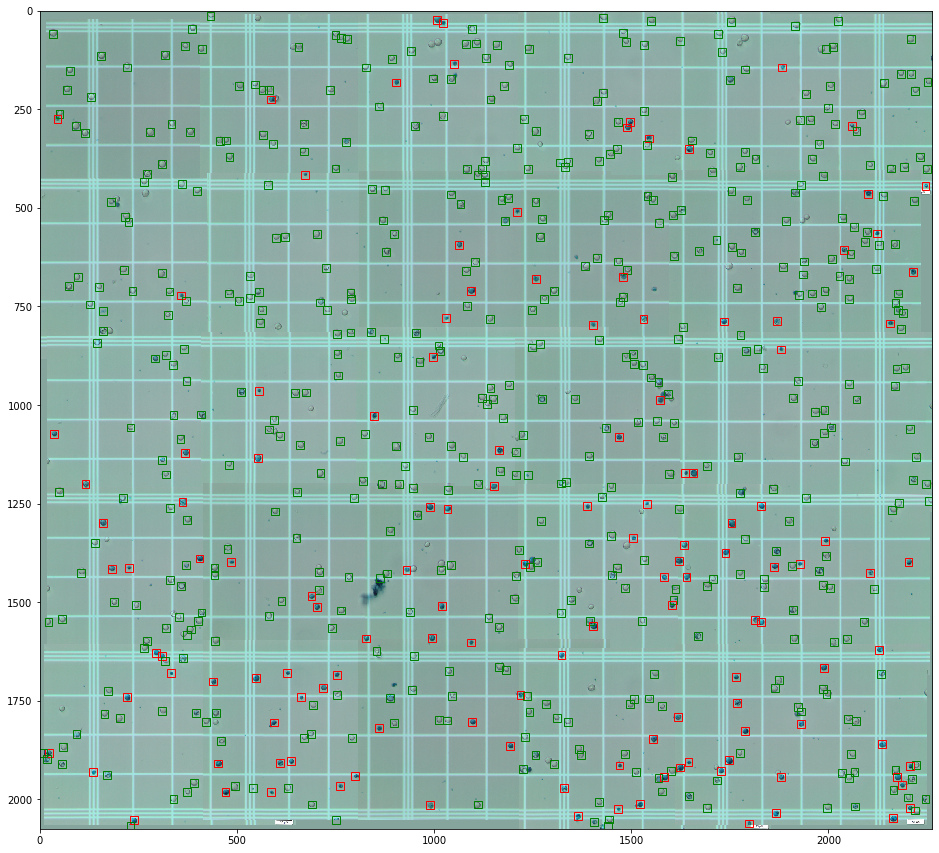

In [3]:
import imageio as im
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import ImageColor
import cv2 as cv
import pickle
import os
import sys
from src.transformations import downsample_img
from src.stitching import stitch_images
from src.cell_detection import detect_cells
from src.cell_classification import classify_cells

base_dir = './sequencia_2/'
image_paths = sorted(os.listdir(base_dir))[1:]
images = [im.imread(f'{base_dir}{path}') for path in image_paths]
downsampled = list(map(lambda img: downsample_img(img, 6), images))
imgs_grid = [
    downsampled[:5],
    downsampled[5:10],
    downsampled[10:15],
    downsampled[15:20],
    downsampled[20:25],
]
stitched_image = stitch_images(imgs_grid)
centers = detect_cells(stitched_image)
with open("classifier.pkl", "rb") as f:
    classifier = pickle.load(f)
with open("label_meanings.pkl", "rb") as f:
    label_meanings = pickle.load(f)
labels, metrics = classify_cells(stitched_image, centers, model=classifier)

label1, label1_points, label1_silhouette = metrics[0]
label2, label2_points, label2_silhouette = metrics[1]
total_points = label1_points + label2_points
label1_probability = np.round(100 * label1_points / total_points, 2)
label2_probability = np.round(100 * label2_points / total_points, 2)
print('----------------------------------------------')
print(f'Estimated {label1_points} ({label1_probability}%) {label_meanings[label1]}')
print(f'Silhouette coefficient: {label1_silhouette}')
print('----------------------------------------------')
print(f'Estimated {label2_points} ({label2_probability}%) {label_meanings[label2]}')
print(f'Silhouette coefficient: {label2_silhouette}')

fig, axis = plt.subplots(1, figsize=(16, 16))
axis.imshow(stitched_image, interpolation='nearest')

colors = ['r', 'g']

for i, (x, y) in enumerate(centers):
    color = colors[labels[i]]
    axis.add_patch(patches.Rectangle((y-10, x-10), 20, 20, edgecolor=color, facecolor='none'))